Calculating joint angles from a kinematic acquisition
=====================================================

In this tutorial, we will calculate the elbow joint angles in the acquisition presented in the previous section. At the end of the tutorial, we will have plotted curves of elbow flexion and pronation angles during the complete acquisition.

Such an analysis is composed of the following steps:

**Step 1.** Read the marker trajectories

For each of the analyzed joint:

**Step 2.** We calculate series of frames to express the orientation of the two segments that compose this joint (how are both segments oriented in space);

**Step 3.** We express a series of homogeneous transforms between the proximal and distal frames (how the distal segment is oriented in space compared to the proximal segment);

**Step 4.** We extract the series of Euler angles from these homogeneous transforms (what series of three angles allow such relative orientation);

**Step 5.** We interpret these Euler angle as rotations around anatomical axes.

In [1]:
import kineticstoolkit.lab as ktk

Read and visualize marker trajectories
--------------------------------------

We proceed exactly as in the previous tutorial:

In [2]:
# Read the markers
markers = ktk.kinematics.read_c3d_file(
    ktk.config.root_folder + '/data/kinematics/racing_full.c3d')

# Set the point of view for 3D visualization
viewing_options = {
    'zoom': 3.5,
    'azimuth': 0.8,
    'elevation': 0.16,
    'translation': (0.2, -0.7)
}

# Define the segments for easier visualization
segments = {
    'ArmR': {
        'Color': [1, 0.25, 0],
        'Links': [['AcromionR', 'MedialEpicondyleR'],
                  ['AcromionR', 'LateralEpicondyleR'],
                  ['AcromionR', 'OlecraneR']]
    },
    'ForearmR': {
        'Color': [1, 0.5, 0],
        'Links': [['MedialEpicondyleR', 'RadialStyloidR'],
                  ['MedialEpicondyleR', 'UlnarStyloidR'],
                  ['LateralEpicondyleR', 'RadialStyloidR'],
                  ['LateralEpicondyleR', 'UlnarStyloidR'],
                  ['OlecraneR', 'RadialStyloidR'],
                  ['OlecraneR', 'UlnarStyloidR'],
                  ['UlnarStyloidR', 'RadialStyloidR']]
    }
}

# Create the player
player = ktk.Player(markers, segments=segments, **viewing_options)

# Show one second (only needed in Notebooks)
player.to_html5(start_time=0, stop_time=1)

Create local coordinate systems
-------------------------------

To calculate the elbow angles, we need to express frames for the arm and forearm segments. The elbow angles will be extracted from the homogeneous transform between both frames.

We will use the recommendations of the International Society of Biomechanics [1] to define these local coordinate systems:

### Arm coordinate system ###

Following the ISB recommendations, the local coordinate system for the humerus is defined as follow:

**1. The origin is GH (glenohumeral joint).**

We don't have a marker for the glenohumeral join, but we have one for the acromion. We will therefore approximate GH by the acromion.

In [3]:
origin = markers.data['AcromionR']

**2. The y axis is the line between GH and the midpoint of EL (lateral elbow epicondyle) and EM (medial elbow epicondyle), pointing to GH**

In [4]:
y = (markers.data['AcromionR'] -
     0.5 * (markers.data['LateralEpicondyleR'] +
            markers.data['MedialEpicondyleR']))

**3. The x axis is the normal to the GH-EL-EM plane, pointing forward**

Since x is normal to the GH-EL-EM plane, this plane is a yz plane. We need to define a second vector (other than y) to form this yz plane.  

In [5]:
yz = markers.data['LateralEpicondyleR'] - markers.data['MedialEpicondyleR']

Note that the direction of the yz vector is important. For the plane normal to be forward, the cross product of y and yz must also point forward. In this case, following the [right-hand/screw rule](https://en.wikipedia.org/wiki/Right-hand_rule), y (upward) cross yz (right) effectively yields a forward vector.

As an easier rule of thumb, look at the next definition: the z vector will point to right. Then just make the yz vector also point to (grossly) right.

**4. The z axis is perpendicular to x and y, pointing to the right.**

We have now defined everything to create the series of humerus frame.

Let's first create an empty TimeSeries for our new frames:

In [6]:
frames = ktk.TimeSeries(time=markers.time)

Now, we will create the `ArmR` frame series.

In [7]:
frames.data['ArmR'] = ktk.geometry.create_frames(
            origin=origin, y=y, yz=yz)

Let's visualize it:

In [8]:
player = ktk.Player(markers, frames,
                    segments=segments, **viewing_options)

# Show one second in this Jupyter notebook
player.to_html5(start_time=0, stop_time=1)

### Forearm frame ###

We will now proceed with the exact same steps to create the forearm coordinate system. From the ISB [1]:

**1. The origin is US (ulnar styloid process).**

In [9]:
origin = markers.data['UlnarStyloidR']

**2. The y axis is the line between US and the midpoint between EL and EM, pointing proximally.**

In [10]:
y = (0.5 * (markers.data['LateralEpicondyleR'] +
            markers.data['MedialEpicondyleR']) -
     markers.data['UlnarStyloidR'])

**3. The x axis is the line perpendicular to the plane through US, RS, and the midpoint between EL and EM, pointing forward.**

**4. The z axis is perpendicular to x and y, pointing to the right.**

This means that US, RS and the elbow center make an yz plane. Since z will point to the right in anatomical position, we will create a yz vector that points grossly to the right in anatomical position.

In [11]:
yz = markers.data['RadialStyloidR'] - markers.data['UlnarStyloidR']

We are now ready to create the `ForearmR` frame series.

In [12]:
frames.data['ForearmR'] = ktk.geometry.create_frames(
            origin=origin, y=y, yz=yz)

Let's visualize our markers with both new frames:

In [13]:
player = ktk.Player(markers, frames,
                    segments=segments, **viewing_options)

# Show one second in this Jupyter notebook
player.to_html5(start_time=0, stop_time=1)

Find the series of homogeneous transforms between both segments
---------------------------------------------------------------

Now that we have expressed frames for both the arm and forearm, we can find the homogeneous transform between both frames. This is equivalent to expressing the forearm frame in the local coordinates system of the arm.

In [14]:
arm_to_forearm = ktk.geometry.get_local_coordinates(
    frames.data['ForearmR'],
    frames.data['ArmR']
)

arm_to_forearm

array([[[-0.89251428, -0.28050878,  0.35317572,  0.07386483],
        [-0.26421245,  0.95981064,  0.09463257, -0.51046091],
        [-0.36552708, -0.0088525 , -0.93075861,  0.00233108],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[-0.86649378, -0.3588741 ,  0.34698403,  0.09357942],
        [-0.29827222,  0.92958265,  0.21658664, -0.50065135],
        [-0.40027767,  0.08417528, -0.91251976, -0.02194941],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[-0.83495161, -0.43573721,  0.3361382 ,  0.11295463],
        [-0.32906148,  0.88488148,  0.32970184, -0.48806881],
        [-0.44110583,  0.16467495, -0.88221755, -0.04268811],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       ...,

       [[-0.01705025, -0.97173028, -0.23547728,  0.24257892],
        [-0.65770179, -0.16648594,  0.73465011, -0.21229573],
        [-0.75308542,  0.1673998 , -0.63627012, -0.04178903],
        [ 0.        ,  0.        ,  0.        ,  1.

Extract the series of Euler angles
----------------------------------

We now have a series of homogeneous matrices, from which we will now extract Euler angles corresponding to flexion and pronation. We will use the [get_angles()](../api/kineticstoolkit.geometry.rst#kineticstoolkit.geometry.get_angles) to extract these Euler angles. We however fist need to define the sequence of rotation for these angles. Still following the recommendations of the International Society of Biomechanics [1], we define the series of rotations from the arm to forearm as:

**First rotation:** Around the humerus' z axis. Corresponds to a flexion (positive) or hyperextension (negative).

**Second rotation:** Around the forearm's rotated x axis. Corresponds to a "carrying angle" due to a tilt in the humeral flexion/extension axis at the humero-ulnar joint and an angulation of the ulna itself.

**Third rotation:** Around the forearm's rotated y axis. Corresponds to a pronation (positive) or supination (negative).

These rotations are relative to moving axes (every other rotation is performed around a new frame generated by the previous rotation). Therefore, we will use 'ZXY' (capital letters) as the sequence of rotations.

In [15]:
euler_angles = ktk.geometry.get_angles(arm_to_forearm, 'ZXY', degrees=True)

euler_angles

array([[ 16.29122882,  -0.50721766, 158.55909435],
       [ 21.10954895,   4.82860191, 156.31529458],
       [ 26.21675916,   9.47835244, 153.43510186],
       ...,
       [ 99.72205703,   9.63667232, 130.19394543],
       [ 97.45324788,   8.52179736, 132.78214513],
       [ 91.37545539,   6.97385903, 132.64566069]])

Plot the Euler angles
---------------------

Now that we calculated the angles, it would be a good idea to create a last TimeSeries to keep track of the time and meaning of these angles.

In [16]:
angles = ktk.TimeSeries(time=markers.time)

angles.data['Elbow flexion'] = euler_angles[:, 0]
angles.data['Forearm pronation'] = euler_angles[:, 2]

angles.add_data_info('Elbow flexion', 'Unit', 'deg')
angles.add_data_info('Forearm pronation', 'Unit', 'deg')

Now we plot it.

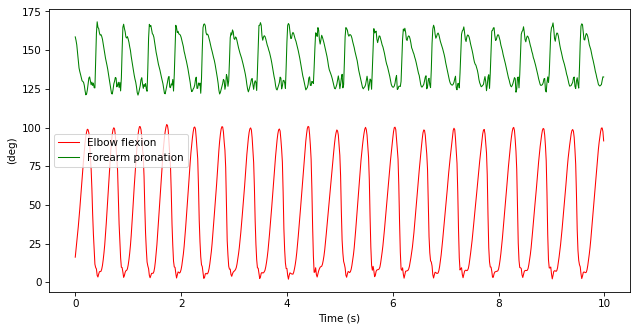

In [17]:
angles.plot()

From this curve, we can now see that the elbow goes from a total extension to a flexion of about 100 degrees, while the forearm stays in a pronated angle of about 125 to 170 degrees (defined from a fully supinated position in anatomical position).

The process would be identical for any joint:

1. Create the series of reference frames for the two segments that compose the analyzed joint;
2. Express the series of rigid transforms from the proximal to distal joint;
3. Extract the series of Euler angles from these rigid transforms;
4. Interpret these Euler angle as anatomical rotation.

[1] G. Wu et al., "ISB recommendation on definitions of joint coordinate systems of various joints for the reporting of human joint motion - Part II: shoulder, elbow, wrist and hand," Journal of Biomechanics, vol. 38, no. 5, pp. 981--992, 2005.